In [36]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
%matplotlib inline

## 隠れマルコフモデル（Hidden Markov Model, HMM）って？

１．ある時点の状態は１つ前の状態のみに依存する（マルコフモデル）

２．状態が直接は観測できない

３．状態に依存して、観測可能な変数の値（の確率分布）が決まる

（例）遠距離の友達、アリスとボブ（Wikipedia）

　遠くに住んでいる友人のアリスとボブがいて、電話で毎日お互い自分のしたことを話している（お前ら友達以上だろ）。ボブは「散歩 (walk)」、「買い物 (shop)」、「掃除 (clean)」の3つのことにしか関心がなく、何をするかは、その日の天気によってのみ決めている。アリスはボブが住んでいる地域の日々の天気については具体的に知らないが、一般的な天候の変化については知っている。ボブが毎日話すことにもとづいて、アリスは天気がどのようになっているかを推測しようとする。アリスは、天気が離散マルコフ過程として変化すると考える。天気には「雨 (Rainy)」と「晴れ (Sunny)」の2つの状態があるが、アリスはそれを直接知ることができないから「隠れ」た状態である。毎日、ボブは天気に応じて「散歩」、「買い物」「掃除」のどれかひとつだけを必ずする。ボブがそれをアリスに話すことが、アリスにとっての観測（ボブからの出力）である。この状況全体が隠れマルコフモデルとなる。アリスは、ボブのいる地域の一般的な天候の変化（遷移確率）については知っている。また、どの天気のときにボブがどの行動をするか（出力確率）を知っている。つまり隠れマルコフモデルのパラメータが既知である。

<img src="hmm.png">

In [3]:
states = ('Rainy', 'Sunny')

observations = ('walk', 'shop', 'clean')

start_probability = {'Rainy': 0.6, 'Sunny': 0.4}

transition_probability = {
    'Rainy': {'Rainy': 0.7, 'Sunny': 0.3},
    'Sunny': {'Rainy': 0.4, 'Sunny': 0.6},
}

emission_probability = {
    'Rainy': {'walk': 0.1, 'shop': 0.4, 'clean': 0.5},
    'Sunny': {'walk': 0.6, 'shop': 0.3, 'clean': 0.1},
}

### 1日目：ボブ「散歩したわ」

(0.24, 0.06)

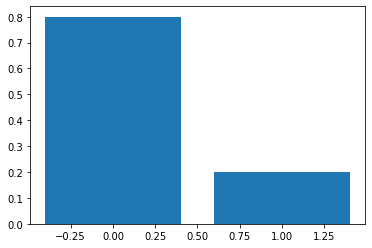

In [22]:
# 初期状態を使って計算
sunny = start_probability['Sunny']*emission_probability['Sunny']['walk']
rainy = start_probability['Rainy']*emission_probability['Rainy']['walk']
s = sunny+rainy
plt.bar(range(2), [sunny/s, rainy/s])
sunny, rainy

### 2日目：ボブ「買物した」

(0.043199999999999995, 0.038400000000000004, 0.005399999999999999, 0.0168)

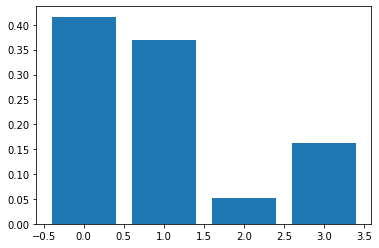

In [23]:
# 昨日の状態を考慮（マルコフ過程、動的計画法DP）

sunny_sunny = sunny*transition_probability['Sunny']['Sunny']*emission_probability['Sunny']['shop']
sunny_rainy = sunny*transition_probability['Sunny']['Rainy']*emission_probability['Rainy']['shop']

rainy_sunny = rainy*transition_probability['Rainy']['Sunny']*emission_probability['Sunny']['shop']
rainy_rainy = rainy*transition_probability['Rainy']['Rainy']*emission_probability['Rainy']['shop']

s = sunny_sunny + sunny_rainy + rainy_sunny + rainy_rainy
plt.bar(range(4), [sunny_sunny/s, sunny_rainy/s, rainy_sunny/s, rainy_rainy/s])

sunny_sunny, sunny_rainy, rainy_sunny, rainy_rainy

### 3日目：ボブ「暇すぎて掃除してもうた」

(0.0025919999999999997,
 0.00864,
 0.001152,
 0.01344,
 0.00032399999999999996,
 0.00108,
 0.000504,
 0.005879999999999999)

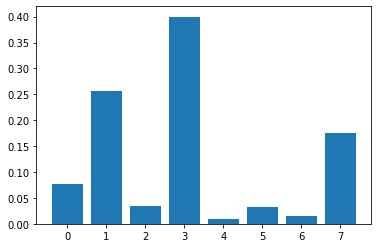

In [24]:
# 昨日の状態を考慮（マルコフ過程、動的計画法DP）
sunny_sunny_sunny = sunny_sunny*transition_probability['Sunny']['Sunny']*emission_probability['Sunny']['clean']
sunny_sunny_rainy = sunny_sunny*transition_probability['Sunny']['Rainy']*emission_probability['Rainy']['clean']

sunny_rainy_sunny = sunny_rainy*transition_probability['Rainy']['Sunny']*emission_probability['Sunny']['clean']
sunny_rainy_rainy = sunny_rainy*transition_probability['Rainy']['Rainy']*emission_probability['Rainy']['clean']

rainy_sunny_sunny = rainy_sunny*transition_probability['Sunny']['Sunny']*emission_probability['Sunny']['clean']
rainy_sunny_rainy = rainy_sunny*transition_probability['Sunny']['Rainy']*emission_probability['Rainy']['clean']

rainy_rainy_sunny = rainy_rainy*transition_probability['Rainy']['Sunny']*emission_probability['Sunny']['clean']
rainy_rainy_rainy = rainy_rainy*transition_probability['Rainy']['Rainy']*emission_probability['Rainy']['clean']

s = sunny_sunny_sunny + sunny_sunny_rainy + sunny_rainy_sunny + sunny_rainy_rainy + rainy_sunny_sunny + rainy_sunny_rainy + rainy_rainy_sunny + rainy_rainy_rainy
plt.bar(range(8), [sunny_sunny_sunny/s, sunny_sunny_rainy/s, sunny_rainy_sunny/s, sunny_rainy_rainy/s, rainy_sunny_sunny/s, rainy_sunny_rainy/s, rainy_rainy_sunny/s, rainy_rainy_rainy/s])

sunny_sunny_sunny,  sunny_sunny_rainy, sunny_rainy_sunny, sunny_rainy_rainy, rainy_sunny_sunny, rainy_sunny_rainy, rainy_rainy_sunny, rainy_rainy_rainy

### アリス「晴れ→雨→晴れだったな」

### ※確率が高いパスを選択するアルゴリズム：ビタビアルゴリズム（動的計画法の一種）

## これ遷移確率や出力確率がわからないと話にならんのでは？

そうです。なので、データからこれらを推定する。色々方法はあると思うが、MCMCでやってみる。

In [95]:
# ダミーデータの生成
# state = 0　は晴れ、state = 1 は雨
# action = 0　は散歩、action = 1 は買物、action = 2 は掃除
p_start = 0.4 # 0.4で晴れ（state = 0）
p_transfer = {0: [0.6, 0.4], 1: [0.3, 0.7]} # key = state, values = [sunny, rainy]
p_action = {0: [0.6, 0.3, 0.1], 1: [0.1, 0.4, 0.5]} # key = state, values = [walk, shop, clean]

N = 1000 # 生成するサンプル数

# データ格納変数
states = np.zeros(N)
actions = np.zeros(N)

# 初期化
state = np.argmax(np.random.multinomial(1, [p_start, 1-p_start], 1))
action = np.argmax(np.random.multinomial(1, p_action[state], 1))
states[0] = state
actions[0] = action

for i in range(N):
    # 0 or 1の状態どちらか、現在の状態によって異なる遷移をする
    state = np.argmax(np.random.multinomial(1, p_transfer[state], 1))
    # 0, 1, 2のどれかの行動を起こすが状態によって異なる、これを観測値とする
    action = np.argmax(np.random.multinomial(1, p_action[state], 1))
    print(state, action)
    states[i] = state
    actions[i] = action

0 0
0 2
0 0
1 2
1 1
1 1
1 2
0 1
0 2
1 2
1 2
0 1
0 1
0 0
1 2
1 1
0 0
0 0
0 1
0 0
1 0
1 1
0 0
0 0
1 0
1 1
1 2
0 0
0 0
0 1
1 2
1 2
0 0
1 1
1 1
1 1
0 1
0 0
0 0
0 0
0 0
1 1
1 2
0 0
1 0
0 0
1 1
0 1
1 0
1 0
1 1
1 0
1 2
1 2
0 0
1 2
0 1
1 2
0 0
0 0
0 0
0 1
1 2
1 2
1 2
1 0
0 1
0 1
0 0
1 0
1 2
1 2
0 2
0 1
0 0
1 2
0 0
1 2
0 0
1 2
1 1
0 2
0 0
0 2
1 1
0 0
1 0
1 1
1 0
1 2
0 0
0 0
1 2
1 2
1 0
1 1
0 0
1 1
1 2
0 0
1 0
0 0
0 0
0 1
1 1
1 2
1 2
0 0
0 1
1 2
1 2
0 1
1 1
1 1
0 0
0 2
0 1
0 1
1 2
1 0
1 1
1 2
0 0
0 0
0 0
1 1
0 0
0 0
0 1
0 2
0 2
1 2
1 2
0 0
0 0
0 2
0 0
0 0
0 0
1 2
1 1
1 2
0 1
0 0
1 1
1 1
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
1 1
0 1
0 0
1 2
1 2
0 0
1 2
1 1
0 0
0 1
0 0
0 2
1 2
1 0
1 0
1 2
1 1
0 2
1 2
1 2
1 1
0 1
0 0
1 2
1 2
0 0
0 0
0 0
0 0
0 0
1 0
1 1
1 1
0 0
0 0
0 1
0 0
1 2
0 1
0 2
0 1
0 1
0 1
1 2
0 1
0 0
0 0
0 1
1 1
1 2
1 1
1 2
1 1
0 1
1 2
1 1
0 0
0 0
0 1
1 1
1 1
1 1
1 2
0 1
1 0
1 1
1 1
1 1
1 2
0 2
0 2
0 1
1 2
1 1
1 1
1 0
1 2
1 1
0 1
1 0
1 2
1 1
1 2
0 1
0 2
1 2
0 1
0 0
1 1
1 2
0 0
0 2
0 2
0 0
0 0
1 1


In [151]:
# 想定通りのデータになっているか確認
p_state_ML = np.zeros([2,2]) # 行：遷移前の状態、列：遷移後の状態
p_action_ML = np.zeros([2,3]) # 行：状態、列：観測

for i in range(N-1):
    before = int(states[i])
    after = int(states[i+1])
    p_state_ML[before][after] = p_state_ML[before][after] + 1
    
    sta = int(states[i])
    act = int(actions[i])
    p_action_ML[sta][act] = p_action_ML[sta][act] + 1

In [152]:
# 遷移のカウント
p_state_ML

array([[253., 184.],
       [184., 378.]])

In [153]:
# 遷移確率
p_state_ML[0] = p_state_ML[0]/p_state_ML[0].sum()
p_state_ML[1] = p_state_ML[1]/p_state_ML[1].sum()
p_state_ML

array([[0.57894737, 0.42105263],
       [0.32740214, 0.67259786]])

In [99]:
# 観測された行動のカウント
p_action_ML

array([[269., 121.,  47.],
       [ 60., 221., 281.]])

In [155]:
# 出力確率
p_action_ML[0] = p_action_ML[0]/p_action_ML[0].sum()
p_action_ML[1] = p_action_ML[1]/p_action_ML[1].sum()
p_action_ML

array([[0.61556064, 0.27688787, 0.10755149],
       [0.10676157, 0.39323843, 0.5       ]])

In [156]:
# hstreyさんのコードをそのまま拝借、これでええんか？と言う気がするのであとで見直す
class HMMStates(pm.Discrete):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P1 : tensor
        probability to remain in state 1
    P2 : tensor
        probability to move from state 2 to state 1
    
    """

    def __init__(self, PA=None, P1=None, P2=None,
                 *args, **kwargs):
        super(HMMStates, self).__init__(*args, **kwargs)
        self.PA = PA
        self.P1 = P1
        self.P2 = P2
        self.mean = 0.
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        PA = self.PA
        P1 = self.P1
        P2 = self.P2
        
        # now we need to create an array with probabilities
        # so that for x=A: PA=P1, PB=(1-P1)
        # and for x=B: PA=P2, PB=(1-P2)
        
        choice = tt.stack((P1,P2))
        P = choice[x[:-1]]
        
        x_i = x[1:]
        
        ou_like = pm.Categorical.dist(P).logp(x_i)
        return pm.Categorical.dist(PA).logp(x[0]) + tt.sum(ou_like)

In [157]:
# hstreyさんのコードをそのまま拝借、これでええんか？と言う気がするのであとで見直す
with pm.Model() as model:
    # 2 state model
    # P1 is probablility to stay in state 1
    # P2 is probability to move from state 2 to state 1
    P1 = pm.Dirichlet('P1', a=np.ones(2))
    P2 = pm.Dirichlet('P2', a=np.ones(2))
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMMStates('states',PA,P1,P2, observed=states)
    
    start = pm.find_MAP()
    
    trace = pm.sample(5000, start=start)

/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` inste

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e865a90>,
      dtype=object)

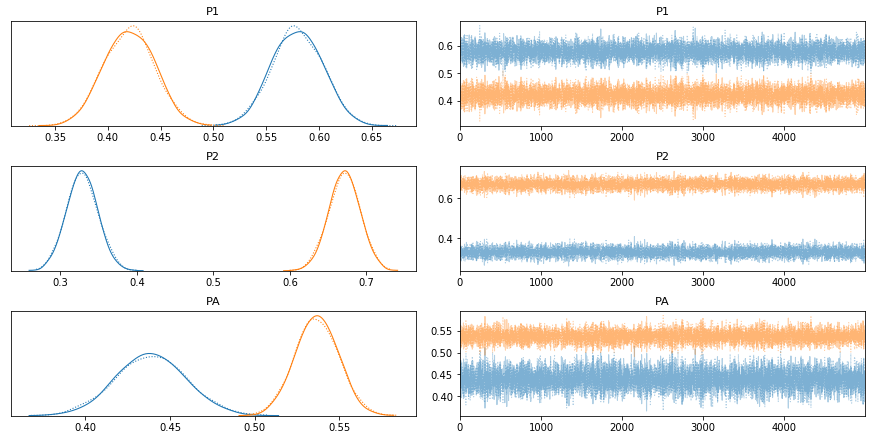

In [158]:
pm.traceplot(trace)

In [159]:
# hstreyさんのコードをそのまま拝借、これでええんか？と言う気がするのであとで見直す
from scipy import optimize
with pm.Model() as model2:
    # 2 state model
    # P1 is probablility to stay in state 1
    # P2 is probability to move from state 2 to state 1
    P1 = pm.Dirichlet('P1', a=np.ones(2))
    P2 = pm.Dirichlet('P2', a=np.ones(2))
    
    S = pm.InverseGamma('S',alpha=2.1, beta=1.1)
    
    PA = pm.Deterministic('PA',P2/(P2+1-P1))
    
    states = HMMStates('states',PA,P1,P2, shape=len(actions))
    
    emission = pm.Normal('emission',
                         mu=tt.cast(states,dtype='float64'),
                         sd=S,
                         observed = actions)
    
    start2 = pm.find_MAP(fmin=optimize.fmin_powell)
    step1 = pm.Metropolis(vars=[P1, P2, S, PA, emission])
    step2 = pm.ElemwiseCategorical(vars=[states], values=[0,1])
    trace2 = pm.sample(10000, start=start, step=[step1,step2])

/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.7/site-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.a

Optimization terminated successfully.
         Current function value: 1672.319011
         Iterations: 2
         Function evaluations: 100


logp = -1,672.3:   2%|▏         | 100/5000 [00:00<00:45, 108.84it/s]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [P2]
>>Metropolis: [P1]
>>Metropolis: [S]
>ElemwiseCategorical: [states]
Sampling 2 chains, 0 divergences:   0%|          | 0/21000 [00:00<?, ?draws/s]/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120a1f828>,
      dtype=object)

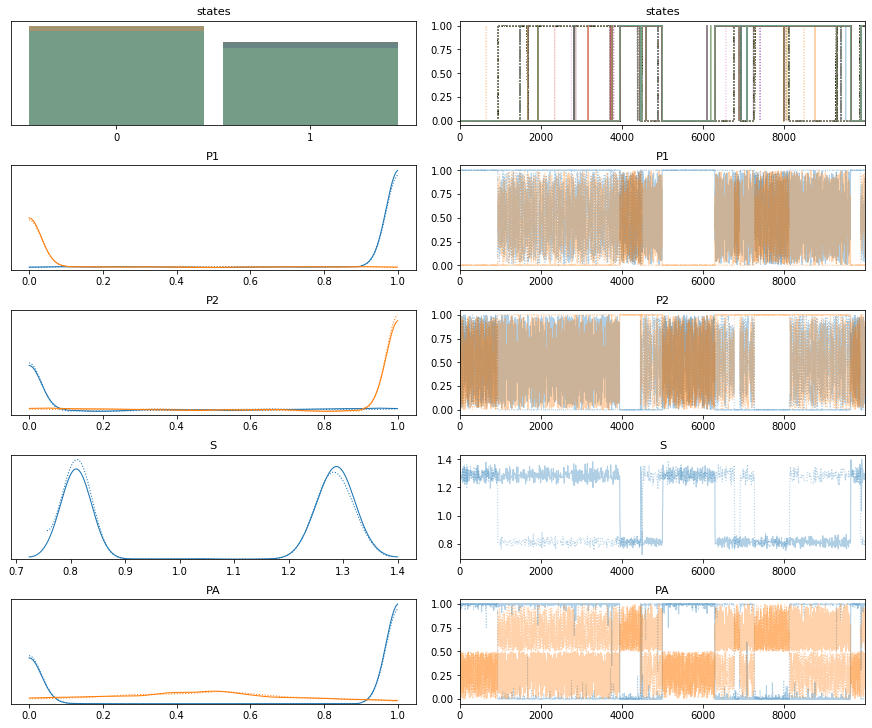

In [160]:
pm.traceplot(trace2)

###  Ref.

http://kento1109.hatenablog.com/entry/2017/12/15/160315

https://github.com/hstrey/Hidden-Markov-Models-pymc3